In [1]:
%config Completer.use_jedi = False

In [2]:
import sys

import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import coord_skyfield
from coord_skyfield import ITRF2TEME

In [4]:
from tlefit_equinoctial_eph_jax import *

In [5]:
df = pd.read_feather('ephemeris/gpsd6n22short.fth')

t = df.timestamp
ephemeris = [((row['x'], row['y'], row['z']), (row['xdot'], row['ydot'], row['zdot'])) for idx, row in df.iterrows()]

ephemeris_teme = ITRF2TEME(t, ephemeris)
ephemeris = ephemeris_teme
t = np.array([_t.to_pydatetime() for _t in t])

/tmp/ipykernel_825819/2830078750.py:8: UserWarning: Discarding nonzero nanoseconds in conversion.
  t = np.array([_t.to_pydatetime() for _t in t])


In [6]:
last_obs = 300
obs_stride = 1
lamda = 1e-3 * 0 + 1
iterations, solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = \
    test_tle_fit_normalized_equinoctial(t, ephemeris, last_obs=last_obs, obs_stride=obs_stride, lamda=lamda, rms_epsilon=0.0001, debug=True)

Initial semi-major axis (a) = 26558.668 km
COE elements (original) = [26558.66821181454, 0.004955996580964593, 0.9534815917054646, 5.5866081275021084, 4.608844240039538, 0.09615470379843861, 1e-06]
Residuals at epoch time [-1.15872338e+01 -1.88040707e+00 -6.43374342e-01 -6.90100427e-04
  6.81057778e-04 -1.47135401e-03]
Residual magnitudes at epoch time 11.7564, 0.00176209


#################### ITERATION 1 ####################

Condition number (A): 552434.741
Condition number (ATWA_acc): 3890524036554012.5
Lambda:  0.1
Residuals after/before 2.62e+04 < 6.88e+09
Covariance a: 217.159 m
dx  [ 1.73672797e+00 -1.69973201e-04 -2.25566410e-04  1.90197416e-04
 -2.19695833e-04  2.84561044e-05  1.44184906e-04]
COE elements = [26560.404939789303, DeviceArray(0.00523526, dtype=float64), DeviceArray(0.95373862, dtype=float64), DeviceArray(5.58631729, dtype=float64), DeviceArray(4.61742971, dtype=float64), DeviceArray(0.08805028, dtype=float64), 0.00014518490602093316]
EQN elements = (26560.404939

In [7]:
with np.printoptions(precision=6, suppress=True):
    print(P)
np.sqrt(P[0][0]) * 1000
np.sqrt(P[0][0]) * 1000

[[ 0.047166  0.        0.       -0.        0.       -0.        0.      ]
 [ 0.        0.        0.       -0.        0.        0.        0.      ]
 [ 0.        0.        0.       -0.       -0.       -0.        0.      ]
 [-0.       -0.       -0.        0.        0.        0.       -0.      ]
 [ 0.        0.       -0.        0.        0.        0.        0.      ]
 [-0.        0.       -0.        0.        0.        0.       -0.      ]
 [ 0.        0.        0.       -0.        0.       -0.        0.      ]]


217.1783061666334

In [8]:
# Split the data into in-spampe and out-of-sample

# Optionally thin the observations
t_is = tt = t[::obs_stride]
eph_is = teph = ephemeris[::obs_stride]

if last_obs:
    t_os = t_is[last_obs:]
    t_is = t_is[:last_obs]
    eph_os = eph_is[last_obs:]
    eph_is = eph_is[:last_obs]

jd, jdf = solve_sat.model.jdsatepoch, solve_sat.model.jdsatepochF
print(sat_epoch_datetime(solve_sat.model))

2006-10-19 02:44:46.999968+00:00


In [9]:
exporter.export_tle(solve_sat.model)

('1 99999U 1800100  06292.11443287  .00000000  00000-0  14521-3 0  9990',
 '2 99999  54.6452 320.0724 0052350 264.5653   5.0388  2.00563044    16')

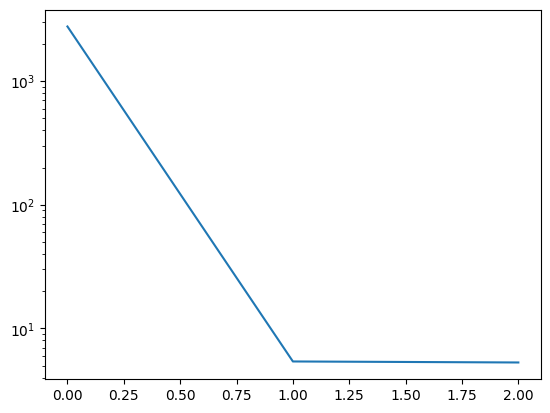

In [10]:
plt.semilogy(range(len(sigmas)), sigmas)

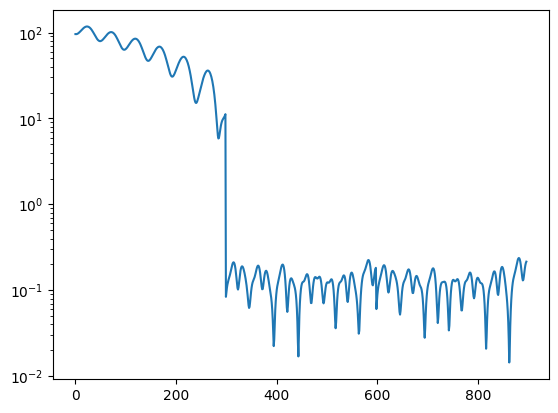

In [11]:
plt.semilogy(bs)

In [12]:
def solution_residuals(t, ephemeris, solve_sat):
    
    bs = []
    
    offset_idxs = range(len(t))
    
    for offset_idx in offset_idxs:

        # Obs - Nom
        jd, jdf = jday_datetime(t[offset_idx])
        res = np.array(ephemeris[offset_idx]) - np.array(solve_sat.model.sgp4(jd, jdf)[1:])
        
        b = np.concatenate((res[0], res[1]))

        #bs.append(np.linalg.norm(b.T @ W @ b))
        bs.append(np.linalg.norm(b.T @ b))
        
    return np.array(bs)

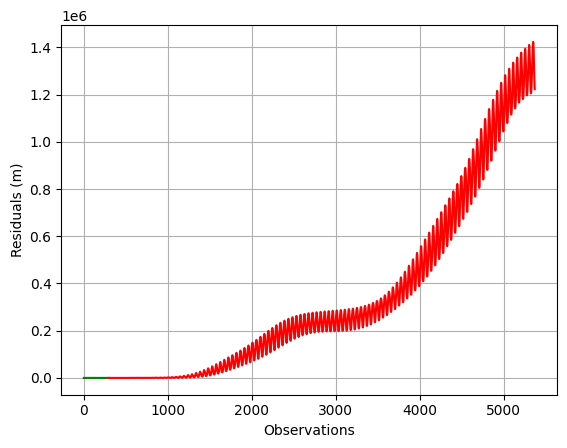

In [13]:
plt.plot(solution_residuals(t_is, eph_is, solve_sat) * 1000, c='g')
plt.plot(range(last_obs, len(tt)), solution_residuals(t_os, eph_os, solve_sat) * 1000, c='r')

plt.xlabel('Observations')
plt.ylabel('Residuals (m)')
plt.grid()

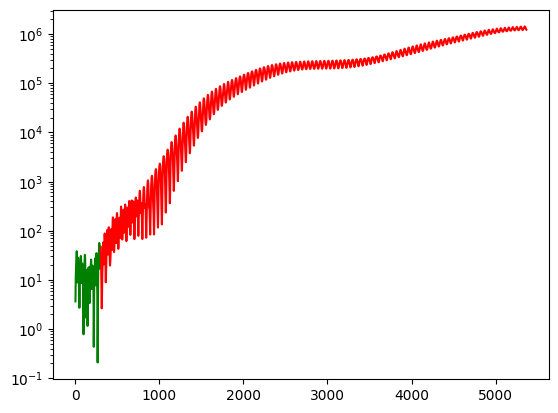

In [14]:
plt.semilogy(solution_residuals(t_is, eph_is, solve_sat) * 1000, c='g')
plt.semilogy(range(last_obs, len(tt)), solution_residuals(t_os, eph_os, solve_sat) * 1000, c='r')

## Find the distance to TLEs with the same launch and proximate epoch

In [15]:
import datetime as dt

import json

from sgp4.conveniences import sat_epoch_datetime, jday_datetime

from spacetrack import SpaceTrackClient
import spacetrack.operators as op

st = SpaceTrackClient(os.environ['SPACETRACK_USER'], os.environ['SPACETRACK_PWD'])

In [16]:
launch_objects = json.loads(st.gp(mean_motion=op.inclusive_range(1.95, 2.05), orderby='TLE_LINE1', format='json'))

In [17]:
[lo for lo in launch_objects if 'NAVSTAR' in lo['OBJECT_NAME']]

[{'CCSDS_OMM_VERS': '2.0',
  'COMMENT': 'GENERATED VIA SPACE-TRACK.ORG API',
  'CREATION_DATE': '2022-12-18T17:49:27',
  'ORIGINATOR': '18 SPCS',
  'OBJECT_NAME': 'OPS 5111 (NAVSTAR 1)',
  'OBJECT_ID': '1978-020A',
  'CENTER_NAME': 'EARTH',
  'REF_FRAME': 'TEME',
  'TIME_SYSTEM': 'UTC',
  'MEAN_ELEMENT_THEORY': 'SGP4',
  'EPOCH': '2022-12-18T02:42:08.339328',
  'MEAN_MOTION': '1.98072313',
  'ECCENTRICITY': '0.00810510',
  'INCLINATION': '63.4576',
  'RA_OF_ASC_NODE': '90.9769',
  'ARG_OF_PERICENTER': '212.2486',
  'MEAN_ANOMALY': '147.2602',
  'EPHEMERIS_TYPE': '0',
  'CLASSIFICATION_TYPE': 'U',
  'NORAD_CAT_ID': '10684',
  'ELEMENT_SET_NO': '999',
  'REV_AT_EPOCH': '31114',
  'BSTAR': '0.00000000000000',
  'MEAN_MOTION_DOT': '-0.00000012',
  'MEAN_MOTION_DDOT': '0.0000000000000',
  'SEMIMAJOR_AXIS': '26782.595',
  'PERIOD': '727.007',
  'APOAPSIS': '20621.536',
  'PERIAPSIS': '20187.385',
  'OBJECT_TYPE': 'PAYLOAD',
  'RCS_SIZE': 'MEDIUM',
  'COUNTRY_CODE': 'US',
  'LAUNCH_DATE': '19

In [18]:
tles = []

sat_ids = [sat['NORAD_CAT_ID'] for sat in launch_objects]

In [19]:
sat_gps = json.loads(st.gp_history(norad_cat_id=','.join(sat_ids),  epoch=op.inclusive_range((sat_epoch_datetime(solve_sat.model) - dt.timedelta(days=1)).date(), (sat_epoch_datetime(solve_sat.model) + dt.timedelta(days=+2)).date()), orderby='TLE_LINE1', format='json'))

In [20]:
def solution_residuals(t, solve_sat, comp_sat):
    
    bs = []
    
    offset_idxs = range(len(t))
    
    for offset_idx in offset_idxs:

        # Obs - Nom
        jd, jdf = jday_datetime(t[offset_idx])
        b = np.ravel(np.array(np.array(solve_sat.sgp4(jd, jdf)[1:] - np.array(comp_sat.sgp4(jd, jdf)[1:]))))[:3]

        bs.append(b.T @ b)
        
    return np.array(bs)

In [21]:
candidates = []

for sat in sat_gps:
    candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)

    res = solution_residuals(t_is, solve_sat.model, candidate_sat.model)
    res_epoch = np.sqrt(res[-1])
    res = np.sqrt(np.mean(res))

    candidates.append((sat["NORAD_CAT_ID"], sat["OBJECT_ID"], sat["EPOCH"], sat["TLE_LINE0"], sat["TLE_LINE1"], sat["TLE_LINE2"], res, res_epoch))

In [22]:
df_candidates = pd.DataFrame(candidates, columns=['norad_cat_id', 'object_id', 'epoch', 'tle_line0', 'tle_line1', 'tle_line2', 'residual', 'residual_epoch'])

In [23]:
df_candidates.sort_values('residual').head(20)

,norad_cat_id,object_id,epoch,tle_line0,tle_line1,tle_line2,residual,residual_epoch
568,28129,2003-058A,2006-10-20T05:39:53.175168,0 NAVSTAR 53 (USA 175),1 28129U 03058A 06293.23603212 -.00000058 0...,2 28129 054.6457 320.0220 0052136 264.7011 094...,2.667964,1.014833
567,28129,2003-058A,2006-10-19T05:43:58.315295,0 NAVSTAR 53 (USA 175),1 28129U 03058A 06292.23886939 -.00000059 +0...,2 28129 054.6464 320.0627 0052109 264.7328 094...,2.685148,0.915499
565,28129,2003-058A,2006-10-18T05:48:03.299040,0 NAVSTAR 53 (USA 175),1 28129U 03058A 06291.24170485 -.00000059 0...,2 28129 054.6471 320.1034 0052084 264.7458 094...,2.798881,0.941797
566,28129,2003-058A,2006-10-18T05:48:03.325823,0 NAVSTAR 53 (USA 175),1 28129U 03058A 06291.24170516 -.00000059 0...,2 28129 054.6470 320.1034 0052057 264.7173 094...,3.076637,1.175152
97,11690,1980-011A,2006-10-20T04:50:54.165120,0 OPS 5117 (NAVSTAR 5),1 11690U 80011A 06293.20201580 -.00000012 +0...,2 11690 063.8937 271.2930 0273259 182.2802 177...,13655.398467,1040.530041
95,11690,1980-011A,2006-10-18T04:59:07.223135,0 OPS 5117 (NAVSTAR 5),1 11690U 80011A 06291.20772249 -.00000006 0...,2 11690 063.8947 271.3546 0272966 182.2597 177...,13655.433771,1036.763506
96,11690,1980-011A,2006-10-19T04:55:00.855263,0 OPS 5117 (NAVSTAR 5),1 11690U 80011A 06292.20487101 -.00000011 +0...,2 11690 063.8945 271.3237 0273183 182.2697 177...,13655.490257,1039.200554
64,10684,1978-020A,2006-10-18T05:30:29.613023,0 OPS 5111 (NAVSTAR 1),1 10684U 78020A 06291.22950941 -.00000008 +0...,2 10684 063.4960 271.4665 0061292 174.6670 185...,14799.212858,10944.563035
66,10684,1978-020A,2006-10-20T05:58:32.334239,0 OPS 5111 (NAVSTAR 1),1 10684U 78020A 06293.24898535 -.00000013 +0...,2 10684 063.4948 271.4050 0061264 174.7138 185...,14799.342105,10945.147804
67,10684,1978-020A,2006-10-20T05:58:32.596032,0 OPS 5111 (NAVSTAR 1),1 10684U 78020A 06293.24898838 -.00000013 0...,2 10684 063.4948 271.4053 0061462 174.4244 185...,14800.350209,10948.427452


In [25]:
sat = sat_gps[6]
candidate_sat = EarthSatellite(sat['TLE_LINE1'], sat['TLE_LINE2'], sat['TLE_LINE0'], ts)
candidate_sat.model.sgp4(jd, jdf)

(0,
 (10668.296087647044, 7292.796722440949, -31842.335182255498),
 (-2.501846359599823, 1.0696316015728493, 0.8648788164327018))

In [26]:
(np.ravel(solve_sat.model.sgp4(jd, jdf)[1:]) - np.ravel(candidate_sat.model.sgp4(jd, jdf)[1:]))[:3]

array([-20613.52006192, -18917.25591717,  10292.77861932])

In [27]:
solve_sat.model.sgp4_tsince(0)

(0,
 (-9945.223974273918, -11624.45919472531, -21549.556562930655),
 (2.976205749750984, -2.5097654537063634, -0.02194336742101166))

In [28]:
candidate_sat.model.sgp4_tsince((sat_epoch_datetime(solve_sat.model) - sat_epoch_datetime(candidate_sat.model)).total_seconds() / 60)

(0,
 (10668.296167702032, 7292.796688214704, -31842.335209930596),
 (-2.5018463562478765, 1.0696316038636393, 0.8648788064260986))

In [29]:
print(sat_epoch_datetime(solve_sat.model), sat_epoch_datetime(candidate_sat.model))
(sat_epoch_datetime(solve_sat.model) - sat_epoch_datetime(candidate_sat.model)).total_seconds()

2006-10-19 02:44:46.999968+00:00 2006-10-20 17:18:13.250016+00:00


-138806.250048

In [30]:
eph_is[0], t_is[0]

((array([-20421.04220671,  16961.05759437,    -48.200446  ]),
  array([-1.41399684, -1.74163053, -3.16097417])),
 datetime.datetime(2006, 10, 15, 23, 59, 47, tzinfo=<UTC>))

In [31]:
candidate_sat.model.sgp4(*jday_datetime(t_is[0]))

(0,
 (30657.74437934246, -6623.393156897523, -25793.922031972415),
 (-0.8113843357046191, 1.142564036944282, -1.6191111000462464))

In [32]:
np.linalg.norm(np.ravel(eph_is[0])[:3] - np.ravel(candidate_sat.model.sgp4(*jday_datetime(t_is[0]))[1:])[:3])

61871.72970205591

## Calculate new TLE at same epoch as Reference / Truth TLE

* Grab the the epoch from the reference (truth) TLE
* Fit all ephemeris so epoch is in the sweet spot of the bathtub
    * This is probably bullshit, since we wouldn't have the future ephemeris yet
* Calculate the predicted state vector at the reference epoch using the fitted model
* add the predicted state vector to our ephemeris
* Re-fit up to the predicted state vector to get the mean elements for the reference epoch
* Compare fitted TLE to reference TLE

### Notes
* Probably better to interpolate ephemeris or use EKF to reference epoch

In [33]:
ref_tle = candidate_sat

In [34]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2006, 10, 20, 17, 18, 13, 250016, tzinfo=UTC)

In [37]:
ajd, ajdf = jday_datetime(sat_epoch_datetime(ref_tle.model))

In [38]:
# We'll do the thinning outside so we can preserve the new epoch

if obs_stride:
    tt = t[::obs_stride]
    et = ephemeris[::obs_stride]

if last_obs:
    tt = tt[:last_obs]
    et = et[:last_obs]

aligned_epoch_obs = np.searchsorted(tt, sat_epoch_datetime(ref_tle.model))
# ii = np.searchsorted(t, sat_epoch_datetime(ref_tle.model))
tt = np.insert(t, aligned_epoch_obs, sat_epoch_datetime(ref_tle.model))
et = ephemeris[:aligned_epoch_obs] + [tuple(np.array(x) for x in ref_tle.model.sgp4(ajd, ajdf)[1:])] + ephemeris[aligned_epoch_obs:] 

In [39]:
sat_epoch_datetime(ref_tle.model)

datetime.datetime(2006, 10, 20, 17, 18, 13, 250016, tzinfo=UTC)

In [40]:
tt[aligned_epoch_obs]

datetime.datetime(2006, 10, 20, 17, 18, 13, 250016, tzinfo=UTC)

In [41]:
iterations, aligned_solve_sat, elements_coe, sigma, sigmas, dxs, bs, lamdas, b_epoch, b_new_epoch, b, P, A = test_tle_fit_normalized_equinoctial(tt, et, last_obs=None, obs_stride=None, epoch_obs=aligned_epoch_obs, lamda=1e-3, rms_epsilon=0.0001, debug=False)

In [42]:
aligned_solve_sat.model.intldesg = ref_tle.model.intldesg
# aligned_solve_sat.model.satnum = ref_tle.model.satnum # FIXME: assign this in satrec at creation
aligned_solve_sat.model.classification = ref_tle.model.classification
# aligned_solve_sat.model.ndot = ref_tle.model.ndot # Useless, but pretty
# aligned_solve_sat.model.nddot = ref_tle.model.nddot# Useless, but pretty

exporter.export_tle(aligned_solve_sat.model)

('1 99999U 72072A   06293.72098669  .00000000  00000-0 -10000+1 0  9992',
 '2 99999  54.6451 320.0064 0052539 264.4273  85.1870  2.00562788    17')

In [43]:
exporter.export_tle(ref_tle.model)

('1 06192U 72072A   06293.72098669  .00000791  00000-0  10000-3 0  9994',
 '2 06192  69.9404 150.1133 5399813  47.6269 347.1851  2.01337587250640')

Text(0, 0.5, 'Position Residual (m)')

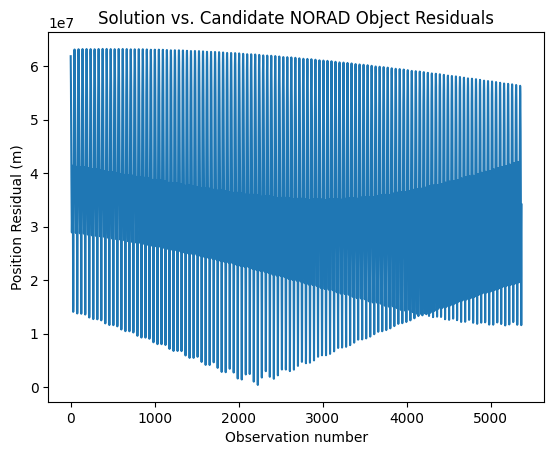

In [44]:
plt.plot(np.sqrt(solution_residuals(t, aligned_solve_sat.model, ref_tle.model)) * 1000)
plt.title("Solution vs. Candidate NORAD Object Residuals")
plt.xlabel("Observation number")
plt.ylabel("Position Residual (m)")